# Convolutional Neural Networks: Application

This notebook is adapted from Deeplearning.ai's online course, Deep Learning.
In this notebook, we will:
- Create a mood classifer using the TF Keras Sequential API
- Build a ConvNet to identify sign language digits using the TF Keras Functional API

**Objectives:**

- Build and train a ConvNet in TensorFlow for a __binary__ classification problem
- Build and train a ConvNet in TensorFlow for a __multiclass__ classification problem
- Explain different use cases for the Sequential and Functional APIs

In [ ]:
# uncomment the following line to install the packages.
# !pip install numpy h5py matplotlib scipy Pillow pandas tensorflow

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
# import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

### Load the Data and Split the Data into Train/Test Sets

This notebook uses the Happy House dataset, which contains images of people's faces. The task is to build a ConvNet to determine whether the individuals in the images are smiling. 

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


The images are **64x64** pixels in RGB format (3 channels).

In [ ]:
index = 12
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

## Layers in TF Keras 

Previously, for study purposes, layers were manually created using NumPy. In this notebook, pre-defined layers in TensorFlow Keras will be used directly.
We built helper functions using `numpy` to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. Keras is a high-level abstraction built on top of TensorFlow, which allows for even more simplified and optimized model creation and training. 

## The Sequential API

We will first create a model using TF Keras' Sequential API, which allows user to build layer by layer, and is ideal for building models where each layer has **exactly one** input tensor and **one** output tensor. 

Using the Sequential API is simple and straightforward, but is only appropriate for simpler, more straightforward tasks.
 

### Create the Sequential Model

The TensorFlow Keras Sequential API can be used to build simple models with layer operations that proceed in a sequential order. 

We can also add layers incrementally to a Sequential model with the `.add()` method, or remove them using the `.pop()` method, much like you would in a regular Python list.

A Sequential model behaves like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters.  Therefore, a Sequential model is not the right choice if the model is non-linear or contains layers with multiple inputs or outputs.

For any layer construction in Keras, the input shape should be specified in advance. This is because in Keras, the shape of the weights is based on the shape of the inputs. The weights are only created when the model first sees some input data. Sequential models can be created by passing a list of layers to the Sequential constructor.

### happyModel

Implement the `happyModel` function below to build the following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Read [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) for more information.

In [5]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
            ## ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
            tf.keras.layers.ZeroPadding2D(padding=(3,3),input_shape=(64, 64, 3), data_format="channels_last"),
            ## Conv2D with 32 7x7 filters and stride of 1
            tf.keras.layers.Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0'),
            ## BatchNormalization for axis 3
            tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0'),
            ## ReLU
            tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
            ## Max Pooling 2D with default parameters
            tf.keras.layers.MaxPooling2D((2, 2), name='max_pool0'),
            ## Flatten layer
            tf.keras.layers.Flatten(),
            ## Dense layer with 1 unit for output & 'sigmoid' activation
            tf.keras.layers.Dense(1, activation='sigmoid', name='fc'),])
    
    return model

In [6]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


#### Expected Output:

```
['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!
```

Once the model is created, we can compile it for training with an optimizer and loss. When the string `accuracy` is specified as a metric, the type of accuracy used will be automatically converted based on the loss function used. This is one of the many optimizations built into TensorFlow that make life easier! To learn more about the compiler operates, check the docs [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

In [7]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

`.summary()` method displays the types of layers, the shape of the outputs, and how many parameters are in each layer. 

In [8]:
happy_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 3

### Train and Evaluate the Model

After creating the model and compiling it with a chosen optimizer and loss function, perform a sanity check on its contents. Once this is done, the model is ready for training!

Simply call `.fit()` to start the training process. There's no need to manually handle mini-batching, saving, or complex backpropagation computations. All of this is managed by TensorFlow, as the dataset already has pre-specified batches. The number of epochs or minibatch size can also be specified if needed (e.g., for an un-batched dataset).


In [9]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 4s 103ms/step - loss: 1.0713 - accuracy: 0.7100
Epoch 2/10
38/38 [==============================] - 4s 97ms/step - loss: 0.3698 - accuracy: 0.8483
Epoch 3/10
38/38 [==============================] - 4s 97ms/step - loss: 0.1883 - accuracy: 0.9350
Epoch 4/10
38/38 [==============================] - 4s 100ms/step - loss: 0.0993 - accuracy: 0.9700
Epoch 5/10
38/38 [==============================] - 4s 98ms/step - loss: 0.0766 - accuracy: 0.9633
Epoch 6/10
38/38 [==============================] - 4s 100ms/step - loss: 0.0780 - accuracy: 0.9750
Epoch 7/10
38/38 [==============================] - 4s 97ms/step - loss: 0.0648 - accuracy: 0.9850
Epoch 8/10
38/38 [==============================] - 4s 97ms/step - loss: 0.0640 - accuracy: 0.9783
Epoch 9/10
38/38 [==============================] - 4s 95ms/step - loss: 0.1763 - accuracy: 0.9267
Epoch 10/10
38/38 [==============================] - 4s 99ms/step - loss: 0.0940 - accuracy: 0.9717


Use `.evaluate()` to assess the model's performance on the test set. This function will display the values of the loss function and the performance metrics specified during model compilation, such as `binary_crossentropy` for the loss and `accuracy`.

In [10]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 30ms/step - loss: 0.1579 - accuracy: 0.9400


[0.15794876217842102, 0.9399999976158142]

## The Functional API

In the second half of the notebook, Keras' flexible [Functional API](https://www.tensorflow.org/guide/keras/functional) will be used to build a ConvNet capable of differentiating between 6 sign language digits.

The Functional API can handle models with non-linear topology, shared layers, and layers with multiple inputs or outputs. While the Sequential API requires the model to move linearly through its layers, the Functional API allows for much more flexibility. The Sequential API can be thought of as a straight line, whereas a Functional model is a graph, allowing nodes of the layers to connect in various ways.

The visual example below shows the linear progression of a Sequential model contrasted with a skip connection, which is one of the many ways a Functional model can be constructed. A skip connection bypasses certain layers in the network and feeds the output to a later layer.


<img src="images/seq_vs_func.png" style="width:350px;height:200px;">

### The SIGNS Dataset

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [11]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

<img src="images/SIGNS.png" style="width:800px;height:300px;">

In [ ]:
# Example of an image from the dataset
index = 3
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

### Split the Data into Train/Test Sets]

In [13]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### Overvie of the Model (Forward Propagation)

In the [Functional API](https://www.tensorflow.org/guide/keras/functional), we create a graph of layers. This is what allows such great flexibility.

First, build the graph of layers by creating an input node that functions as a callable object:

- **input_img = tf.keras.Input(shape=input_shape):** 

Then, create a new node in the graph of layers by calling a layer on the `input_img` object: 

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Read the full documentation on [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples the input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, it usually operate on a single example at a time and a single channel at a time. Read the full documentation on [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the elementwise ReLU of Z (which can be any shape). Read the full documentation on [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the output computed using a fully connected layer. Read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In the last function above (`tf.keras.layers.Dense()`), the fully connected layer automatically initializes weights in the graph and keeps on training them while training the model. Hence, we don't to initialize those weights when initializing the parameters.

Lastly, before creating the model, we will need to define the output using the last of the function's compositions (in this example, a Dense layer): 

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)**


#### Window, kernel, filter, pool

The words "kernel" and "filter" are used to refer to the same thing. The word "filter" accounts for the amount of "kernels" that will be used in a single convolution layer. "Pool" is the name of the operation that takes the max or average value of the kernels. 

This is why the parameter `pool_size` refers to `kernel_size`, and `(f,f)` refers to the filter size. 

Pool size and kernel size refer to the same thing in different objects - They refer to the shape of the window where the operation takes place. 

### convolutional_model

In [14]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tf.keras.layers.Conv2D(filters = 8 , kernel_size= (4,4), strides = (1,1), padding='same')(input_img)
    ## RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8), strides=(8, 8), padding='same')(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(filters = 16 , kernel_size= (2,2), strides = (1,1), padding='same')(P1)
    ## RELU
    A2 = tf.keras.layers.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4), strides=(4, 4), padding='same')(A2)
    ## FLATTEN
    F = tf.keras.layers.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [15]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(conv_model), output)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)         

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model! 

<a name='4-4'></a>
### 4.4 - Train the Model

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 2s 118ms/step - loss: 1.7915 - accuracy: 0.1796 - val_loss: 1.7854 - val_accuracy: 0.2583
Epoch 2/100
17/17 [==============================] - 2s 111ms/step - loss: 1.7828 - accuracy: 0.2426 - val_loss: 1.7817 - val_accuracy: 0.2750
Epoch 3/100
17/17 [==============================] - 2s 112ms/step - loss: 1.7784 - accuracy: 0.2787 - val_loss: 1.7781 - val_accuracy: 0.3083
Epoch 4/100
17/17 [==============================] - 2s 111ms/step - loss: 1.7741 - accuracy: 0.2852 - val_loss: 1.7738 - val_accuracy: 0.2750
Epoch 5/100
17/17 [==============================] - 2s 112ms/step - loss: 1.7694 - accuracy: 0.3046 - val_loss: 1.7688 - val_accuracy: 0.3417
Epoch 6/100
17/17 [==============================] - 2s 107ms/step - loss: 1.7633 - accuracy: 0.3500 - val_loss: 1.7631 - val_accuracy: 0.3417
Epoch 7/100
17/17 [==============================] - 2s 106ms/step - loss: 1.7564 - accuracy: 0.3537 - val_loss: 1.7558 - val_accuracy: 0.3917

Epoch 58/100
17/17 [==============================] - 2s 112ms/step - loss: 0.5306 - accuracy: 0.8287 - val_loss: 0.6267 - val_accuracy: 0.7750
Epoch 59/100
17/17 [==============================] - 2s 112ms/step - loss: 0.5227 - accuracy: 0.8343 - val_loss: 0.6211 - val_accuracy: 0.7750
Epoch 60/100
17/17 [==============================] - 2s 111ms/step - loss: 0.5150 - accuracy: 0.8361 - val_loss: 0.6161 - val_accuracy: 0.7750
Epoch 61/100
17/17 [==============================] - 2s 111ms/step - loss: 0.5079 - accuracy: 0.8389 - val_loss: 0.6113 - val_accuracy: 0.7917
Epoch 62/100
17/17 [==============================] - 2s 111ms/step - loss: 0.5003 - accuracy: 0.8417 - val_loss: 0.6055 - val_accuracy: 0.7917
Epoch 63/100
17/17 [==============================] - 2s 111ms/step - loss: 0.4931 - accuracy: 0.8444 - val_loss: 0.6005 - val_accuracy: 0.7917
Epoch 64/100
17/17 [==============================] - 2s 111ms/step - loss: 0.4860 - accuracy: 0.8463 - val_loss: 0.5944 - val_accuracy:

## History Object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that can be retrieved at `history.history`: 

In [17]:
history.history

{'loss': [1.7915385961532593,
  1.7828104496002197,
  1.7783501148223877,
  1.7740639448165894,
  1.7693794965744019,
  1.7633190155029297,
  1.7563618421554565,
  1.746798038482666,
  1.7343899011611938,
  1.7184531688690186,
  1.6956130266189575,
  1.6664427518844604,
  1.6290704011917114,
  1.586224913597107,
  1.5417485237121582,
  1.4949456453323364,
  1.4458186626434326,
  1.3993288278579712,
  1.353061556816101,
  1.3085908889770508,
  1.2656062841415405,
  1.2233141660690308,
  1.1819214820861816,
  1.143367886543274,
  1.1076762676239014,
  1.0737074613571167,
  1.0400358438491821,
  1.007849097251892,
  0.9776886105537415,
  0.9493211507797241,
  0.9217327833175659,
  0.8958735466003418,
  0.8715278506278992,
  0.8489891886711121,
  0.8271524906158447,
  0.8062761425971985,
  0.7864426374435425,
  0.7674899101257324,
  0.749813437461853,
  0.7334656715393066,
  0.7176902890205383,
  0.70259690284729,
  0.6884503960609436,
  0.6759501695632935,
  0.6626648306846619,
  0.649992

Now visualize the loss over time using `history.history`: 

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

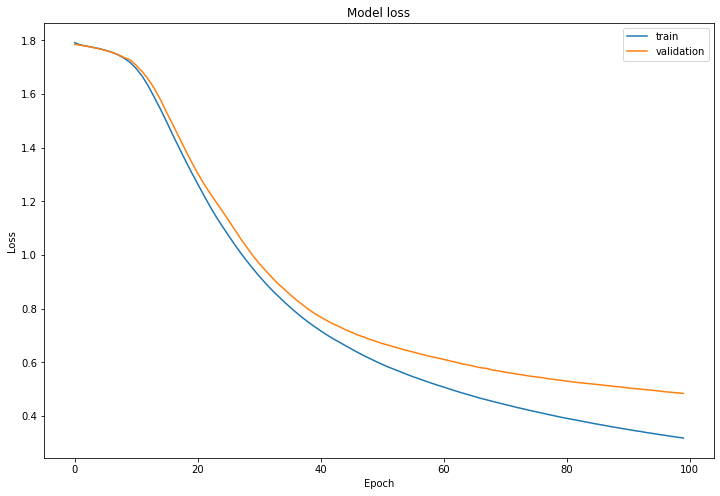

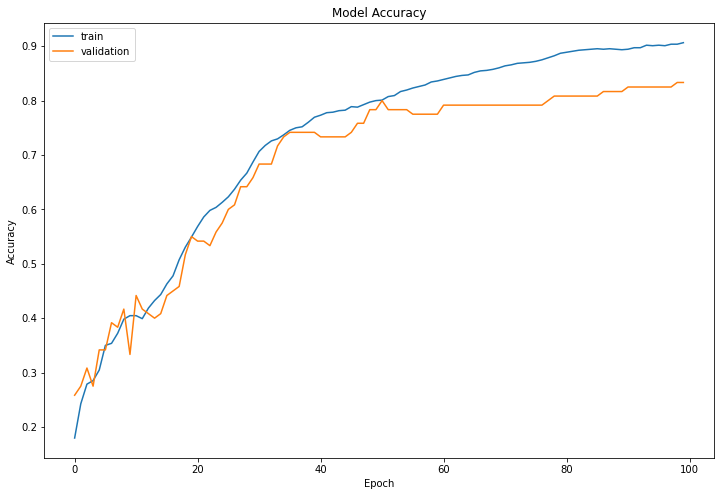

In [18]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')